# Energy Dataset Model Validation and Selection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df_loaded = pd.read_csv("../Part5_Feature_Selection/energydata_complete_hyperpara.csv")
df = df_loaded

# Creating Metrics Dataframe
metrics_df = pd.DataFrame(index = ['n_estimators', 'RSquared_train', 'RSquared_test', 'RMS_train', 'RMS_test', 'MAE_train', 'MAE_test', 'MAPE_train', 'MAPE_test'])

In [3]:
X = df.drop(['Appliances'],axis=1)
y = df['Appliances']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [4]:
# Function to print metrics
def print_training_metrics(**kwargs):
    for name, value in kwargs.items():
        value = float("{0:.2f}".format(value))
        print('{0} for Training Dataset is: {1}'.format(name, value))
def print_testing_metrics(**kwargs):
    for name, value in kwargs.items():
        value = float("{0:.2f}".format(value))
        print('{0} for Testing Dataset is: {1}'.format(name, value))

# Function to print and add metrics to dataframe
def print_metrics(df, model, estimators, r2_train, rms_train, mae_train, mape_train, r2_test, rms_test, mae_test, mape_test):
    #print('R Squared for Training Data:',float("{0:.2f}".format(r2_train)))
    #print('R Squared for Testing Data:',float("{0:.2f}".format(r2_test)))
    #print('RMS for Training Data:',float("{0:.2f}".format(rms_train)))
    #print('RMS for Testing Data:',float("{0:.2f}".format(rms_test)))
    #print('MAE for Training Data:',float("{0:.2f}".format(mae_train)))
    #print('MAE for Testing Data:',float("{0:.2f}".format(mae_test)))
    #print('MAPE for Training Data:',float("{0:.2f}".format(mape_train)))
    #print('MAPE for Testing Data:',float("{0:.2f}".format(mape_test)))
    
    model_name = str.join('_', (model, str(estimators)))
    df[model_name] = [estimators,
                 float("{0:.2f}".format(r2_train)), float("{0:.2f}".format(r2_test)),
                 float("{0:.2f}".format(rms_train)), float("{0:.2f}".format(rms_test)),
                 float("{0:.2f}".format(mae_train)), float("{0:.2f}".format(mae_test)),
                 float("{0:.2f}".format(mape_train)), float("{0:.2f}".format(mape_test))]
    return df

## First Run of Random Forest Model

In [5]:
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

def model_randomforest(X_train, y_train, metrics_df, estimators = 10):
    rf = RandomForestRegressor(n_estimators = estimators)
    rf.fit(X_train, y_train)
    
    # Predicting and Calculating the Metrices for Prediction of Testing Dataset
    prediction_test_rf = rf.predict(X_test)
    r2_test_rf = r2_score(y_test, prediction_test_rf)
    rms_test_rf = sqrt(mean_squared_error(y_test, prediction_test_rf))
    mae_test_rf = mean_absolute_error(y_test,prediction_test_rf)
    mape_test_rf = np.mean(np.abs((y_test - prediction_test_rf) / y_test)) * 100
    
    # Predicting and Calculating the Metrices for Prediction of Training Dataset
    prediction_train_rf = rf.predict(X_train)
    r2_train_rf = r2_score(y_train, prediction_train_rf)
    rms_train_rf = sqrt(mean_squared_error(y_train, prediction_train_rf))
    mae_train_rf = mean_absolute_error(y_train,prediction_train_rf)
    mape_train_rf = np.mean(np.abs((y_train - prediction_train_rf) / y_train)) * 100
    
    # Printing the training and testing metrices
    print('Random Forest Model\n')
    metrics_df = print_metrics(metrics_df, 'RF_Model', estimators, r2_train_rf, rms_train_rf, mae_train_rf, mape_train_rf, r2_test_rf, rms_test_rf, mae_test_rf, mape_test_rf)
    return metrics_df

In [6]:
metrics_df = model_randomforest(X_train, y_train, metrics_df, estimators = 10)
metrics_df

Random Forest Model



,RF_Model_10
n_estimators,10.00
RSquared_train,0.92
RSquared_test,0.56
RMS_train,29.44
RMS_test,65.97
MAE_train,12.95
MAE_test,31.59
MAPE_train,13.11
MAPE_test,32.68


## Model Validation via Cross-Validation
> In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:
 * A model is trained using k-5 of the folds as training data;
 * the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.

![Cross-Validation](./Images/05.03-5-fold-CV.png)

In [8]:
from sklearn.cross_validation import cross_val_score

rf = RandomForestRegressor()
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R2: -0.18 (+/- 0.63)


Above, is the mean score and the 95% confidence interval of the score estimate

In [ ]:
'''
df_loaded_original = pd.read_csv("../Part3_Feature_Engineering/energydata_complete_transformed.csv")
df_original = df_loaded_original
X_original = df_original.drop(['Appliances'],axis=1)
y_original = df_original['Appliances']
scores = cross_val_score(rf, X_original, y_original, cv=5, scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
'''

## The Bias-variance trade-off ~ Selecting the Best Model
>Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between bias and variance. Consider the following figure, which presents two regression fits to the same dataset:
* The model on the left attempts to find a straight-line fit through the data. 
* The model on the right attempts to fit a high-order polynomial through the data.

>The score here is the R2 score, or coefficient of determination, which measures how well a model performs relative to a simple mean of the target values. R2=1 indicates a perfect match, R2=0 indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models. From the scores associated with these two models, we can make an observation that holds more generally:
* For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
* For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

![Bias-variance trade-off](./Images/05.03-bias-variance-2.png)

If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

![Bias-variance trade-off](./Images/05.03-validation-curve.png)

The diagram shown here is often called a validation curve, and we see the following essential features:
* The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
* For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
* For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
* For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

In [8]:
for i in range(10, 510, 10):
    metrics_df = model_randomforest(X_train, y_train, metrics_df, estimators = i)

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest Model

Random Forest

In [9]:
metrics_df

,RF_Model_10,RF_Model_20,RF_Model_30,RF_Model_40,RF_Model_50,RF_Model_60,RF_Model_70,RF_Model_80,RF_Model_90,RF_Model_100,...,RF_Model_410,RF_Model_420,RF_Model_430,RF_Model_440,RF_Model_450,RF_Model_460,RF_Model_470,RF_Model_480,RF_Model_490,RF_Model_500
n_estimators,10.00,20.00,30.00,40.00,50.00,60.00,70.00,80.00,90.00,100.00,...,410.00,420.00,430.00,440.00,450.00,460.00,470.00,480.00,490.00,500.00
RSquared_train,0.92,0.93,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.95,...,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95
RSquared_test,0.53,0.55,0.57,0.58,0.57,0.57,0.57,0.58,0.58,0.58,...,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58
RMS_train,28.74,26.26,25.57,24.71,24.69,24.59,24.30,24.13,24.12,23.94,...,23.44,23.51,23.47,23.55,23.65,23.60,23.61,23.52,23.59,23.51
RMS_test,69.99,68.39,66.75,66.15,66.82,67.07,66.60,66.42,66.21,66.28,...,65.74,65.72,65.82,65.70,65.99,65.95,65.91,66.03,65.91,65.73
MAE_train,12.75,12.04,11.91,11.69,11.62,11.51,11.44,11.40,11.43,11.36,...,11.19,11.19,11.22,11.18,11.25,11.23,11.23,11.23,11.24,11.22
MAE_test,33.13,32.26,31.43,31.47,31.68,31.64,31.45,31.25,30.96,31.07,...,31.03,30.97,31.04,30.94,31.03,31.00,30.93,31.11,31.03,31.03
MAPE_train,13.02,12.33,12.14,12.01,12.00,11.83,11.69,11.69,11.69,11.63,...,11.50,11.50,11.54,11.49,11.55,11.54,11.52,11.54,11.52,11.55
MAPE_test,33.04,32.46,31.70,31.88,32.00,31.86,31.72,31.36,30.99,31.13,...,31.27,31.15,31.22,31.12,31.14,31.13,31.00,31.27,31.20,31.26


Text(0.5,0,'Model Complexity (n_estimators)')

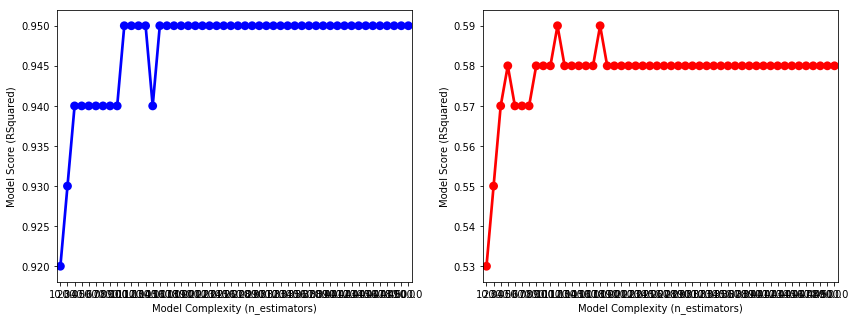

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,5), ncols=2)
sns.pointplot(x='n_estimators', y='RSquared_train', data=metrics_df.T, ax=ax1, color='blue', label='Train', linestyle='-')
sns.pointplot(x='n_estimators', y='RSquared_test', data=metrics_df.T, ax=ax2, color='red', label='Test', linestyle='-')
ax1.set_ylabel('Model Score (RSquared)')
ax1.set_xlabel('Model Complexity (n_estimators)')
ax2.set_ylabel('Model Score (RSquared)')
ax2.set_xlabel('Model Complexity (n_estimators)')

## Validation in Practice: Grid Search

In [ ]:
#!pip install Pipeline
from sklearn.grid_search import GridSearchCV
#from sklearn.preprocessing import PolynomialRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer


param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))


grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

X = df.drop(['Appliances'],axis=1)
y = df['Appliances']


grid.fit(X_train, y_train)
grid.best_params_
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);

C:\Users\Ankur\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Regularization (L1, L2, Elastic net) 

Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term in order to prevent the coefficients to fit so perfectly to overfit. The difference between the L1 and L2 is just that L2 is the sum of the square of the weights, while L1 is just the sum of the weights. 

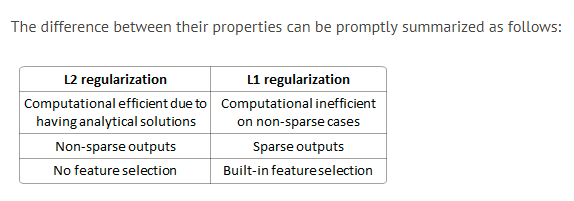